# Using BioGRID to search for synthetically lethal partners

## Table of Contents**

1. **Setup and Configuration**
2. **Helper Functions**
3. **API Query Class**
4. **Data Validation with Great Expectations**
5. **Data Processing and Visualization**
6. **Network Analysis**
7. **Main Workflow**
8. **Automated Monitoring and Reporting**

### **1. Setup and Configuration**

- Set up the environment, load API keys, and define project directories.
- Set up great-expectations version 1.3.2

In [1]:
%pip install -q great_expectations pandas numpy matplotlib seaborn networkx requests python-dotenv


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import great_expectations and request a Data Context.
import great_expectations as gx

#context = gx.get_context(mode="file")

# Optional. Request a File Data Context from a specific folder.
context = gx.get_context(mode="file", project_root_dir="./low_expectations")

# Optional. Review the configuration of the returned File Data Context.
print(context)

{
  "checkpoint_store_name": "checkpoint_store",
  "config_variables_file_path": "uncommitted/config_variables.yml",
  "config_version": 4.0,
  "data_context_id": "25af5c38-40b5-46ea-840a-f98673ad5857",
  "data_docs_sites": {
    "local_site": {
      "class_name": "SiteBuilder",
      "show_how_to_buttons": true,
      "store_backend": {
        "class_name": "TupleFilesystemStoreBackend",
        "base_directory": "uncommitted/data_docs/local_site/"
      },
      "site_index_builder": {
        "class_name": "DefaultSiteIndexBuilder"
      }
    }
  },
  "expectations_store_name": "expectations_store",
  "fluent_datasources": {},
  "plugins_directory": "plugins/",
  "stores": {
    "expectations_store": {
      "class_name": "ExpectationsStore",
      "store_backend": {
        "class_name": "TupleFilesystemStoreBackend",
        "base_directory": "expectations/"
      }
    },
    "validation_results_store": {
      "class_name": "ValidationResultsStore",
      "store_backend": {
 

In [3]:
print(gx.__version__)

1.3.2


In [4]:
import os
from pathlib import Path
from dotenv import load_dotenv
import requests

# Load environment variables from .env file
load_dotenv()
BG_INT_ACCESS_KEY = os.getenv("BG_INT_ACCESS_KEY")
BG_INT_BASE_URL = os.getenv("BG_INT_BASE_URL")

if not BG_INT_ACCESS_KEY or not BG_INT_BASE_URL:
    raise ValueError("BG_INT_ACCESS_KEY or BG_INT_BASE_URL is missing from the .env file.")

# Define interim directory
INTERIM_DIR = Path("../data/interim")
INTERIM_DIR.mkdir(parents=True, exist_ok=True)

### **2. Helper Functions**

Utility functions for validating API responses, transforming JSON to DataFrame, and performing exploratory data analysis (EDA).

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def validate_biogrid_response(response):
    """Validate the structure of the BioGRID API response."""
    if not isinstance(response, dict):
        raise ValueError("Response is not a dictionary of records.")

    required_keys = ['BIOGRID_INTERACTION_ID', 'ENTREZ_GENE_A', 'ENTREZ_GENE_B']
    for record_id, record in response.items():
        for key in required_keys:
            if key not in record:
                raise ValueError(f"Missing required key: {key} in record ID: {record_id}")

def convert_biogrid_json_to_df(json_data):
    """Convert BioGRID JSON data to a pandas DataFrame."""
    df = pd.DataFrame.from_dict(json_data, orient="index")  # Use 'index' orientation
    df['PUBLICATION_YEAR'] = df['PUBMED_AUTHOR'].str.extract(r'\((\d{4})\)').astype("Int64")
    return df

def plot_data_distribution(df):
    """Plot data distribution for publication years."""
    sns.histplot(df['PUBLICATION_YEAR'].dropna(), kde=True)
    plt.title("Publication Year Distribution")
    plt.show()

### **3. API Query Class**

Encapsulate interaction with the BioGRID API.

In [6]:
import json

class BioGRIDQuery:
    def __init__(self):
        self.access_key = BG_INT_ACCESS_KEY
        self.base_url = BG_INT_BASE_URL

    def query_interactions(self, **params):
        """Query the BioGRID API."""
        response = requests.get(f"{self.base_url}/interactions/", params=params)
        response.raise_for_status()
        return response.json()

    def save_response(self, data, file_name):
        """Save API response to a file."""
        file_path = INTERIM_DIR / file_name
        with open(file_path, "w") as f:
            json.dump(data, f, indent=4)

### **4. Data Validation with Great Expectations**

Integrate GE to ensure data quality at critical stages.

In [9]:
import great_expectations as gx
from great_expectations.core.batch import Batch
from great_expectations.validator.validator import Validator
from great_expectations.execution_engine.pandas_execution_engine import PandasExecutionEngine

def validate_biogrid_data(df):
    """Use Great Expectations to validate BioGRID data."""

    # Create a Batch from the DataFrame
    batch = Batch(data=df)

    # Initialize a PandasExecutionEngine
    execution_engine = PandasExecutionEngine()

    # Create a Validator
    validator = Validator(execution_engine=execution_engine, batches=[batch])

    # Define Expectations
    validator.expect_column_values_to_not_be_null("OFFICIAL_SYMBOL_A")
    validator.expect_column_values_to_not_be_null("OFFICIAL_SYMBOL_B")
    validator.expect_column_values_to_be_unique("BIOGRID_INTERACTION_ID")
    validator.expect_column_values_to_be_between("PUBLICATION_YEAR", min_value=1900, max_value=2025)

    # Validate the dataset and print results
    validation_results = validator.validate()
    print(validation_results)

    if not validation_results["success"]:
        raise ValueError("Data validation failed. Check expectations.")

### **5. Data Processing and Visualization**

Transform validated data into a clean DataFrame and visualize its properties.

In [10]:
def process_and_visualize_data(json_data):
    df = convert_biogrid_json_to_df(json_data)
    validate_biogrid_data(df)  # Validate the data with Great Expectations
    plot_data_distribution(df)
    return df

### **6. Network Analysis**

Create and analyze a graph representation of the data using NetworkX.

In [11]:
import networkx as nx

def create_networkx_graph(df):
    """Create a NetworkX graph from the DataFrame."""
    G = nx.Graph()
    for _, row in df.iterrows():
        G.add_node(row["OFFICIAL_SYMBOL_A"], entrez_id=row["ENTREZ_GENE_A"])
        G.add_node(row["OFFICIAL_SYMBOL_B"], entrez_id=row["ENTREZ_GENE_B"])
        G.add_edge(row["OFFICIAL_SYMBOL_A"], row["OFFICIAL_SYMBOL_B"])
    return G

def analyze_networkx_graph(G):
    """Analyze and visualize the NetworkX graph."""
    print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
    sns.histplot(dict(G.degree()).values(), kde=True)
    plt.title("Degree Distribution")
    plt.show()

def create_networkx_graph_with_validation(df):
    validate_biogrid_data(df)  # Revalidate before graph creation
    G = nx.Graph()
    for _, row in df.iterrows():
        G.add_node(row["OFFICIAL_SYMBOL_A"], entrez_id=row["ENTREZ_GENE_A"])
        G.add_node(row["OFFICIAL_SYMBOL_B"], entrez_id=row["ENTREZ_GENE_B"])
        G.add_edge(row["OFFICIAL_SYMBOL_A"], row["OFFICIAL_SYMBOL_B"])
    return G

### **7. Main Workflow**

Combine all components into a cohesive pipeline.

In [12]:
import json

# Initialize the API query class
biogrid_query = BioGRIDQuery()

# Query BioGRID API for interactions
pubmed_article = "35559673"
evidence_list = "synthetic lethality|negative genetic"
params = {
    "taxId": "9606",
    "pubmedList": pubmed_article,
    "includeInteractors": "true",
    "evidenceList": evidence_list,
    "includeEvidence": "true",
    "format": "json",
    "accesskey": biogrid_query.access_key
}
response = biogrid_query.query_interactions(**params)
biogrid_query.save_response(response, f"pmid_{pubmed_article}_interactions.json")

/home/donbr/kgmgmt/kg_rememberall/.venv/lib/python3.11/site-packages/great_expectations/expectations/expectation.py:1453: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(


Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

/home/donbr/kgmgmt/kg_rememberall/.venv/lib/python3.11/site-packages/great_expectations/expectations/expectation.py:1453: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(


Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

/home/donbr/kgmgmt/kg_rememberall/.venv/lib/python3.11/site-packages/great_expectations/expectations/expectation.py:1453: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(


Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

/home/donbr/kgmgmt/kg_rememberall/.venv/lib/python3.11/site-packages/great_expectations/expectations/expectation.py:1453: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(


Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/19 [00:00<?, ?it/s]

{
  "success": true,
  "results": [
    {
      "success": true,
      "expectation_config": {
        "type": "expect_column_values_to_not_be_null",
        "kwargs": {
          "column": "OFFICIAL_SYMBOL_A"
        },
        "meta": {}
      },
      "result": {
        "element_count": 475,
        "unexpected_count": 0,
        "unexpected_percent": 0.0,
        "partial_unexpected_list": []
      },
      "meta": {},
      "exception_info": {
        "raised_exception": false,
        "exception_traceback": null,
        "exception_message": null
      }
    },
    {
      "success": true,
      "expectation_config": {
        "type": "expect_column_values_to_not_be_null",
        "kwargs": {
          "column": "OFFICIAL_SYMBOL_B"
        },
        "meta": {}
      },
      "result": {
        "element_count": 475,
        "unexpected_count": 0,
        "unexpected_percent": 0.0,
        "partial_unexpected_list": []
      },
      "meta": {},
      "exception_info": {
       

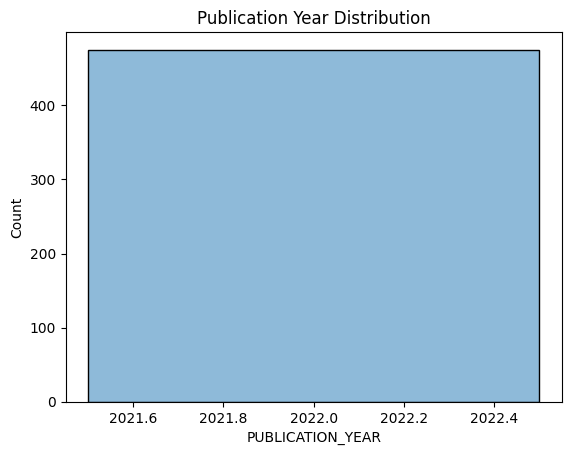

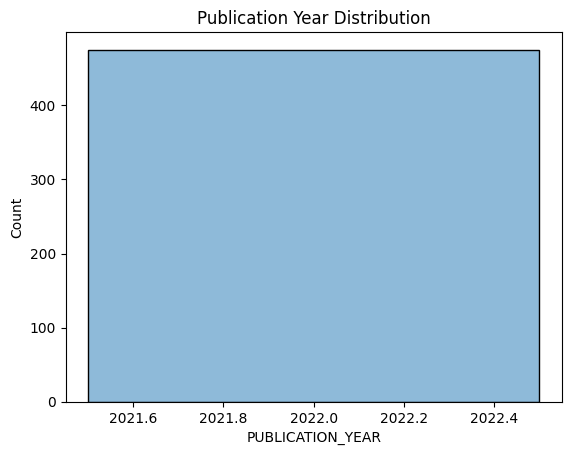

/home/donbr/kgmgmt/kg_rememberall/.venv/lib/python3.11/site-packages/great_expectations/expectations/expectation.py:1453: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(


Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

/home/donbr/kgmgmt/kg_rememberall/.venv/lib/python3.11/site-packages/great_expectations/expectations/expectation.py:1453: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(


Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

/home/donbr/kgmgmt/kg_rememberall/.venv/lib/python3.11/site-packages/great_expectations/expectations/expectation.py:1453: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(


Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

/home/donbr/kgmgmt/kg_rememberall/.venv/lib/python3.11/site-packages/great_expectations/expectations/expectation.py:1453: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(


Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/19 [00:00<?, ?it/s]

{
  "success": true,
  "results": [
    {
      "success": true,
      "expectation_config": {
        "type": "expect_column_values_to_not_be_null",
        "kwargs": {
          "column": "OFFICIAL_SYMBOL_A"
        },
        "meta": {}
      },
      "result": {
        "element_count": 475,
        "unexpected_count": 0,
        "unexpected_percent": 0.0,
        "partial_unexpected_list": []
      },
      "meta": {},
      "exception_info": {
        "raised_exception": false,
        "exception_traceback": null,
        "exception_message": null
      }
    },
    {
      "success": true,
      "expectation_config": {
        "type": "expect_column_values_to_not_be_null",
        "kwargs": {
          "column": "OFFICIAL_SYMBOL_B"
        },
        "meta": {}
      },
      "result": {
        "element_count": 475,
        "unexpected_count": 0,
        "unexpected_percent": 0.0,
        "partial_unexpected_list": []
      },
      "meta": {},
      "exception_info": {
       

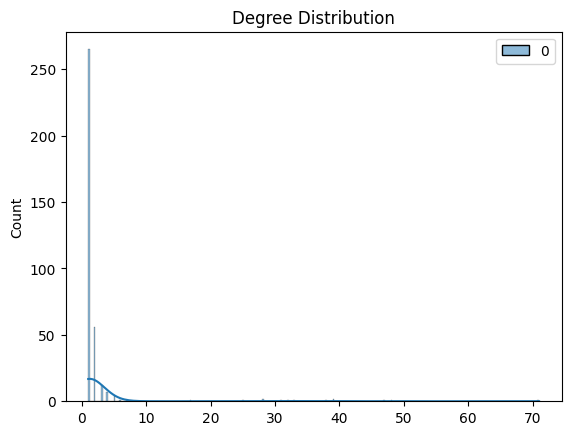

In [13]:
# Fetch, validate, and process data
df = process_and_visualize_data(response)
plot_data_distribution(df)  # Optional EDA step

# Create and analyze graph
G = create_networkx_graph_with_validation(df)
analyze_networkx_graph(G)

### **8. Automated Monitoring and Reporting**

Set up **Great Expectations** for automated monitoring and reporting:
- Validate data at each pipeline step using `run_validation_operator()`.
- Generate data quality documentation:
- Integrate with alerting tools (e.g., Slack, email) for failed validations.

In [15]:
# Build docs
context.build_data_docs()

# Optionally, open the docs in your browser
context.open_data_docs()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 475 entries, 3410710 to 3411553
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   BIOGRID_INTERACTION_ID    475 non-null    int64 
 1   ENTREZ_GENE_A             475 non-null    object
 2   ENTREZ_GENE_B             475 non-null    object
 3   BIOGRID_ID_A              475 non-null    int64 
 4   BIOGRID_ID_B              475 non-null    int64 
 5   SYSTEMATIC_NAME_A         475 non-null    object
 6   SYSTEMATIC_NAME_B         475 non-null    object
 7   OFFICIAL_SYMBOL_A         475 non-null    object
 8   OFFICIAL_SYMBOL_B         475 non-null    object
 9   SYNONYMS_A                475 non-null    object
 10  SYNONYMS_B                475 non-null    object
 11  EXPERIMENTAL_SYSTEM       475 non-null    object
 12  EXPERIMENTAL_SYSTEM_TYPE  475 non-null    object
 13  PUBMED_AUTHOR             475 non-null    object
 14  PUBMED_ID            

## Appendix

### BioGRID Ineraction Sevice

#### Protein, Genetic and Chemical Interactions
- Site URL:  https://thebiogrid.org/
- API docs:  https://wiki.thebiogrid.org/doku.php/biogridrest
- API base url:  https://webservice.thebiogrid.org
- API key:  https://webservice.thebiogrid.org

### Role of **Great Expectations** in the Workflow

- **Validation at Ingestion**: Catches data issues immediately after API calls.
- **Consistency in Processing**: Ensures transformations preserve schema and data quality.
- **Documentation**: Produces dynamic, shareable reports.
- **Monitoring**: Detects and alerts for anomalies in production.

This updated workflow ensures **end-to-end data quality management**, enabling reliable integration of BioGRID data into NetworkX.

### Role of Great Expectations in Data Quality

**Great Expectations (GE)** serves as a validation layer in the pipeline, ensuring that:
- **Input Data Integrity**: Validates data fetched from the BioGRID API.
- **Consistency**: Confirms the expected schema, non-null constraints, and unique identifiers.
- **Scalability**: Generates automated data quality reports for stakeholders.
- **Production Monitoring**: Detects anomalies and enforces data quality in real-time.

By integrating GE, you safeguard the pipeline, ensuring only high-quality data is processed and visualized.